In [81]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler 

#set the name of the column that contain the dependent variable y.
y_column = 'meanOpinionScore'

#Read data from CSV
sessionRegressionDF = pd.read_csv('data/sessionRegressionDF.csv', delimiter = ',')

# Ignore some columns if needed
sessionRegressionDF = sessionRegressionDF.drop(columns=["qosItems_IPL_Subnet_L2", "qosItems_IPR_Subnet_L2"])

# ##############################################
# Keep only values from the "Bad" calls, where 1 < MOS < 3.5
sessionRegressionDF = sessionRegressionDF[(sessionRegressionDF.meanOpinionScore < 3.5) & (sessionRegressionDF.meanOpinionScore > 1)]

# ##############################################
# Remove all rows that MOS is NaN
sessionRegressionDF = sessionRegressionDF.dropna(subset=[y_column])


# ##############################################
# Remove all columns that the number of blank values is > 50%
countOfNaN = sessionRegressionDF.isna().sum()
columnstoDrop = []
for columnIndex in sessionRegressionDF.columns:
    total_rows = sessionRegressionDF[columnIndex].count() + 1
    if countOfNaN[columnIndex] > (0.5 * total_rows):
        columnstoDrop.append(columnIndex)

sessionRegressionDF = sessionRegressionDF.drop(columns=columnstoDrop)

# ##############################################
# Update the independent variables that will be used and then drop all rows that the feature's value is NaN 
independentVariables = list(sessionRegressionDF.columns)
sessionRegressionDF = sessionRegressionDF.dropna(subset = independentVariables)


### ##################################################
# Identify the columns that contain Categorical and Nummeric data.
categoricalColumns = []
numericColumns = []
# Replace the String values with a Enumeration
for colDependencies in sessionRegressionDF.columns:
    columnDataType = sessionRegressionDF.dtypes[colDependencies]
    if(columnDataType == 'object'):
        #sessionRegressionDF[colDependencies] = sessionRegressionDF[colDependencies].astype("category").cat.codes
        categoricalColumns.append(colDependencies)
    else:
        numericColumns.append(colDependencies)
        
# Create dummy values for columns that contain Categorical data 
sessionRegressionDF = pd.get_dummies(sessionRegressionDF, columns=categoricalColumns)

# MinMaxScaler preserves the shape of the original distribution. 
# It doesn't meaningfully change the information embedded in the original data. 
# Note that MinMaxScaler doesn't reduce the importance of outliers. 
# The default range for the feature returned by MinMaxScaler is 0 to 1
scaler = MinMaxScaler()
sessionRegressionDF[numericColumns] = scaler.fit_transform(sessionRegressionDF[numericColumns])


### ##################################################
# Remove columns that its variance is 0.0. These variables are not affecting the Y
columnstoDrop = []
for colDependencies in sessionRegressionDF.columns:
    variance = sessionRegressionDF.var()[colDependencies]
    if variance == 0.0:
        columnstoDrop.append(colDependencies)

sessionRegressionDF = sessionRegressionDF.drop(columns=columnstoDrop)


# Remove outliers using the z-score
sessionRegressionDF = sessionRegressionDF[(np.abs(stats.zscore(sessionRegressionDF)) < 2.5).all(axis=1)]


# Calculate the correlation between all variables and remove one of them if the correlation is > 0.8
sessionRegressionDF_without_y = sessionRegressionDF.drop(columns=[y_column])
correlation_matrix = sessionRegressionDF_without_y.corr().round(2).abs()

upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape),k=1).astype(bool))
columnstoDrop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.8)]
sessionRegressionDF = sessionRegressionDF.drop(columns=columnstoDrop)


# ##################################################
# Set the Target (Y) to 'meanOpinionScore' and then delete the meanOpinionScore from the list of independent variables
target = pd.DataFrame(sessionRegressionDF[y_column], columns=[y_column])
sessionRegressionDF = sessionRegressionDF.drop(columns=[y_column])

# ##################################################
# Update the list of independent variables based on the latest calculations
independentVariables = list(sessionRegressionDF.columns)


# ##################################################
# Create the model

X = sessionRegressionDF[independentVariables]
Y = target[y_column]

X_Const = sm.add_constant(X)

model = sm.OLS(Y, X_Const)
regressionResult = model.fit()

# ##################################################
# Print out the statistics
print(regressionResult.summary())


print("\n\n=======================================================================================")
print("List of parameters ordered by abs(coef) and p-value < 0.05")
lowPvalues = regressionResult.pvalues[regressionResult.pvalues < 0.005]
lowPvaluesNames = lowPvalues.index.tolist()
listOfSignificantFactors = regressionResult.params.filter(items=lowPvaluesNames).abs().sort_values(ascending=False).index.tolist()

print(regressionResult.params.filter(items=listOfSignificantFactors))


                            OLS Regression Results                            
Dep. Variable:       meanOpinionScore   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     526.1
Date:                Thu, 12 Aug 2021   Prob (F-statistic):          2.78e-246
Time:                        15:55:04   Log-Likelihood:                 754.58
No. Observations:                 476   AIC:                            -1487.
Df Residuals:                     465   BIC:                            -1441.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
qosItems_LA            -1.1005    

<AxesSubplot:>

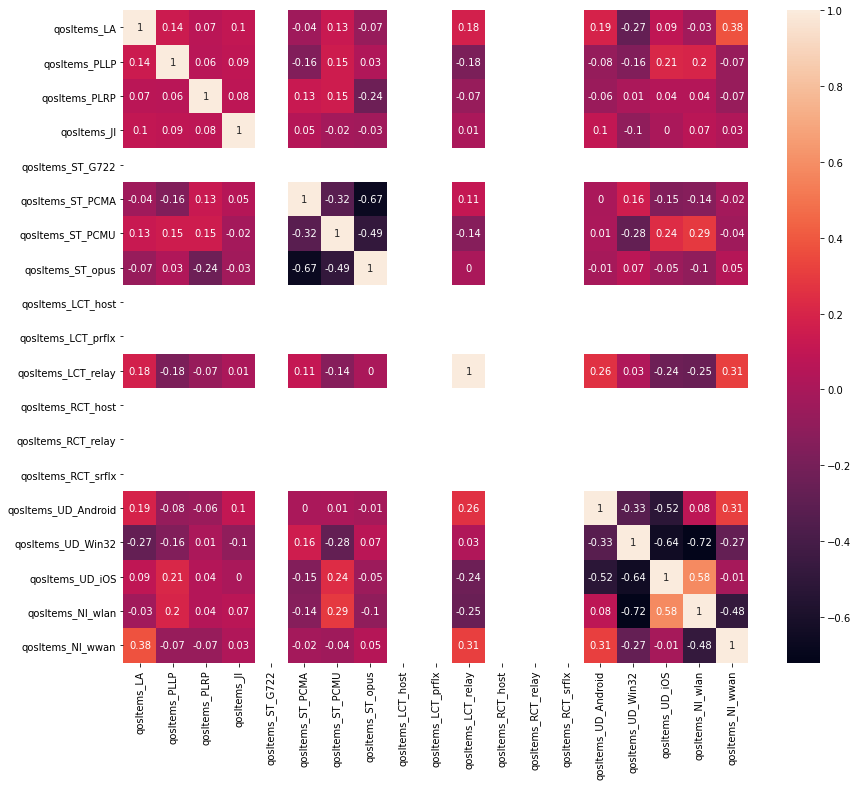

In [82]:
correlation_matrix = sessionRegressionDF.corr().round(2)
plt.figure(figsize=(14, 12))  
sns.heatmap(data=correlation_matrix, annot=True)

In [ ]:
fig = plt.figure(figsize=(12, 24))
fig = sm.graphics.plot_ccpr_grid(regressionResult, fig=fig)